#DataPREP

In [1]:
!unzip /content/dataset5.zip

Archive:  /content/dataset5.zip
  inflating: cirrhosis.csv           


In [2]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.7 MB/s eta 0:00:00


#Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
import numpy as np
from tqdm import tqdm
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import VarianceThreshold

In [19]:
import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense
import tensorflow as tf

#EDA

In [4]:
df = pd.read_csv("/content/cirrhosis.csv").set_index("ID")
print(df.shape)
df.head()

(418, 19)


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

In [6]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [7]:
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()
df_num_col = df.select_dtypes(include=(['int64', 'float64'])).columns
for c in df_num_col:
    df[c].fillna(df[c].median(), inplace=True)

df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [8]:
df.select_dtypes(include=('object')).isna().sum()

Status            0
Drug            106
Sex               0
Ascites         106
Hepatomegaly    106
Spiders         106
Edema             0
dtype: int64

In [9]:
df_cat_col = df.select_dtypes(include=('object')).columns
for c in df_cat_col:
    df[c].fillna(df[c].mode().values[0], inplace=True)

df.select_dtypes(include=('object')).isna().sum()

Status          0
Drug            0
Sex             0
Ascites         0
Hepatomegaly    0
Spiders         0
Edema           0
dtype: int64

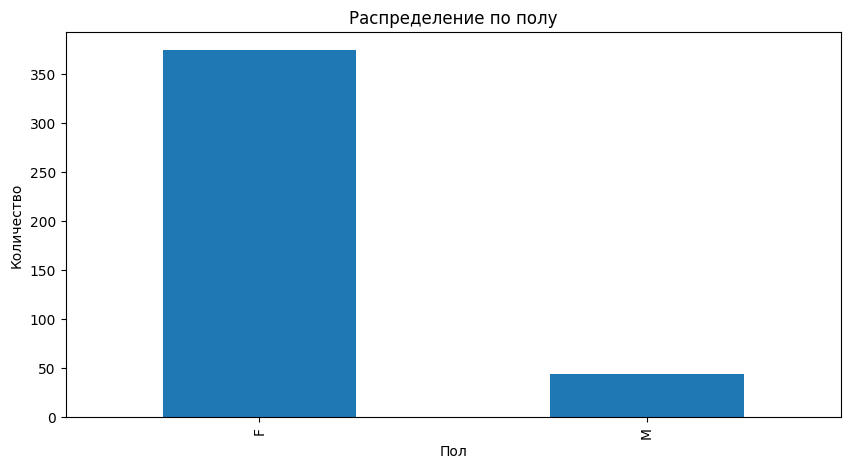

In [10]:
# Гистограмма для признака 'sex'
plt.figure(figsize=(10, 5))
df['Sex'].value_counts().plot(kind='bar')
plt.title('Распределение по полу')
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.show()

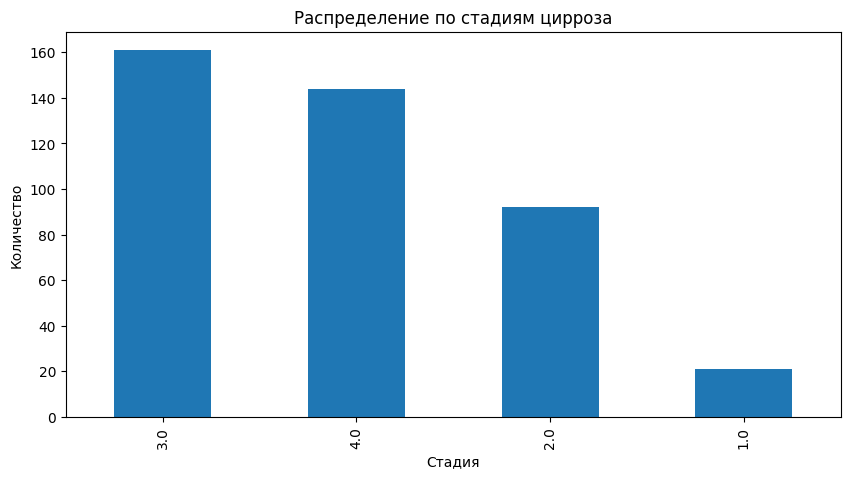

In [11]:
plt.figure(figsize=(10, 5))
df['Stage'].value_counts().plot(kind='bar')
plt.title('Распределение по стадиям цирроза')
plt.xlabel('Стадия')
plt.ylabel('Количество')
plt.show()

In [12]:
df['Stage'] = np.where(df['Stage'] == 4,1,0)

Text(0.5, 1.0, 'Распределение по полу')

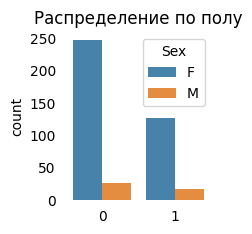

In [13]:
plt.subplot(2,3,1)
sns.countplot(x=df['Stage'], hue=df['Sex'],alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Распределение по полу')

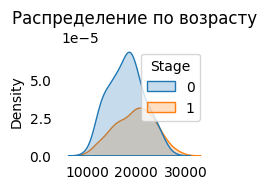

In [14]:
plt.subplot(3,3,4)
sns.kdeplot(x=df['Age'], hue=df['Stage'], fill=True, common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Распределение по возрасту');

In [15]:
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})
df['Ascites'] = df['Ascites'].replace({'N':0, 'Y':1})
df['Drug'] = df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})
df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N':0, 'Y':1})
df['Spiders'] = df['Spiders'].replace({'N':0, 'Y':1})
df['Edema'] = df['Edema'].replace({'N':0, 'Y':1, 'S':-1})
df['Status'] = df['Status'].replace({'C':0, 'CL':1, 'D':-1})

In [16]:
X = df.drop(['Status', 'N_Days', 'Stage'], axis=1)
y = df.pop('Stage')

In [17]:
X.head()

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
ID,,,,,,,,,,,,,,,,
1,0,21464,1,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2
2,0,20617,1,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6
3,0,25594,0,0,0,0,-1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0
4,0,19994,1,0,1,1,-1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3
5,1,13918,1,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
def catboost_fit_n_predict(X_train, y_train):
    params = {'learning_rate': 0.013000000000000001, 'depth': 9, 'l2_leaf_reg': 4.0, 'min_child_samples': 16}
    catboost = CatBoostClassifier(**params,
                loss_function='CrossEntropy',
                thread_count = -1,
                iterations=10000,
                od_type = "Iter",
                od_wait = 100
    )
    catboost.fit(X_train, y_train, verbose=1000)
    pickle.dump(catboost, open('catboost_model.pkl', 'wb'))

In [30]:
def xgboost_fit_n_predict( X_train, y_train):
    xgboost = xgb.XGBClassifier(colsample_bylevel=0.9302223936374205,
                 colsample_bytree=0.9429378401963584, grow_policy='lossguide',
                 learning_rate=0.14274564481193724, max_depth=0, max_leaves=251,
                 min_child_weight=0.08755625167703927, n_estimators=10000, n_jobs=-1,
                 reg_alpha=0.007824467127046418, reg_lambda=3.359652218351442,
                 subsample=0.6859925748081124, tree_method='hist',
                 use_label_encoder=False, verbosity=1)
    xgboost.fit(X_train, y_train)
    pickle.dump(xgboost, open('xgboost_model.pkl', 'wb'))

In [36]:
def mlp_fit(X_train, y_train, X_validation, y_validation):
    epochs = 64
    batch = 32
    lr = 0.00003
    adam = optimizers.Adam(lr)
    model_mlp = Sequential()
    model_mlp.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
    model_mlp.add(Dense(128, activation='relu'))
    model_mlp.add(Dense(64, activation='relu'))
    model_mlp.add(Dense(32, activation='relu'))
    model_mlp.add(Dense(16, activation='relu'))
    model_mlp.add(Dense(8, activation='relu'))
    model_mlp.add(Dense(4, activation='relu'))
    model_mlp.add(Dense(1, activation='sigmoid'))
    model_mlp.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])
    callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    model_mlp.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch, verbose=1, callbacks=callbacks)
    pickle.dump(model_mlp, open('mlp_model.pkl', 'wb'))

In [28]:
catboost_fit_n_predict(X_train, y_train)

0:	learn: 0.6867212	total: 75.8ms	remaining: 12m 37s
1000:	learn: 0.0377054	total: 14.3s	remaining: 2m 8s
2000:	learn: 0.0138482	total: 35.2s	remaining: 2m 20s
3000:	learn: 0.0083115	total: 46.3s	remaining: 1m 47s
4000:	learn: 0.0057938	total: 58.5s	remaining: 1m 27s
5000:	learn: 0.0044386	total: 1m 10s	remaining: 1m 10s
6000:	learn: 0.0035898	total: 1m 22s	remaining: 55.2s
7000:	learn: 0.0030072	total: 1m 35s	remaining: 40.7s
8000:	learn: 0.0026079	total: 1m 47s	remaining: 26.8s
9000:	learn: 0.0023171	total: 1m 58s	remaining: 13.1s
9999:	learn: 0.0020969	total: 2m 9s	remaining: 0us


In [31]:
xgboost_fit_n_predict( X_train, y_train)

In [37]:
mlp_fit(X_train, y_train, X_test, y_test)

Epoch 1/64
11/11 [==============================] - 2s 27ms/step - loss: 200.7129 - binary_accuracy: 0.3443 - val_loss: 165.5658 - val_binary_accuracy: 0.3452
Epoch 2/64
11/11 [==============================] - 0s 8ms/step - loss: 154.2631 - binary_accuracy: 0.3443 - val_loss: 124.5081 - val_binary_accuracy: 0.3452
Epoch 3/64
11/11 [==============================] - 0s 8ms/step - loss: 109.2048 - binary_accuracy: 0.3443 - val_loss: 76.8694 - val_binary_accuracy: 0.3452
Epoch 4/64
11/11 [==============================] - 0s 10ms/step - loss: 74.6203 - binary_accuracy: 0.3443 - val_loss: 60.7503 - val_binary_accuracy: 0.3452
Epoch 5/64
11/11 [==============================] - 0s 9ms/step - loss: 55.4620 - binary_accuracy: 0.3443 - val_loss: 44.0924 - val_binary_accuracy: 0.3452
Epoch 6/64
11/11 [==============================] - 0s 9ms/step - loss: 41.1407 - binary_accuracy: 0.3443 - val_loss: 32.8043 - val_binary_accuracy: 0.3452
Epoch 7/64
11/11 [==============================] - 0s 10

In [38]:
!zip models.zip -r models

  adding: models/ (stored 0%)
  adding: models/xgboost_model.pkl (deflated 84%)
  adding: models/mlp_model.pkl (deflated 41%)
  adding: models/catboost_model.pkl (deflated 90%)
